<a href="https://colab.research.google.com/github/diaa-shalaby/NLP-Sentiment-analysis-thedeep/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
# files.upload()

In [112]:
!git clone https://github.com/diaa-shalaby/NLP-Sentiment-analysis-thedeep.git


Cloning into 'NLP-Sentiment-analysis-thedeep'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [113]:
%cp NLP.ipynb /content/NLP-Sentiment-analysis-thedeep

cp: cannot stat 'NLP.ipynb': No such file or directory


In [23]:
import numpy as np
from numba import njit
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import timeit
import re

import pandas as pd
import numpy as np
import itertools
import spacy
import gensim
import sklearn

from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models import LogEntropyModel
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import gensim.downloader as api
from gensim.models import Word2Vec

from scipy import stats
import random

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm_notebook

from argparse import Namespace
import dill
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
# from transformers import BertTokenizer, BertModel, BertConfig

Exploring dataset

In [25]:
DATASET_SIZE = 'small' # or medium

TRAIN_DATA_PATH = f"thedeep.{DATASET_SIZE}.train.txt"
VALID_DATA_PATH = f"thedeep.{DATASET_SIZE}.validation.txt"
TEST_DATA_PATH = f"thedeep.{DATASET_SIZE}.test.txt"
LABEL_CAPTIONS_PATH = "thedeep.labels.txt"


#Set Hyperparameter for Bag of Words 
MAX_NB_WORDS = 20_000

nlp = spacy.load("en_core_web_sm")

In [26]:
def load_dataset(data_path):
    df_data = pd.read_csv(data_path, sep=',', header = None, names=['sentence_id', 'text', 'label'])
    return df_data

In [34]:
# Load the data into train, validation and test set
df_train = load_dataset(TRAIN_DATA_PATH)
df_test = load_dataset(TEST_DATA_PATH)
df_valid = load_dataset(VALID_DATA_PATH)

# Sample 10% for faster training on limited resources
df_train = df_train.sample(frac=0.1)
df_test = df_test.sample(frac=0.1)
df_valid = df_valid.sample(frac=0.1)

In [35]:
# Print out shapes of the sets
print(f'Train set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')
print(f'Validation set shape: {df_valid.shape}')

df_train.head()

Train set shape: (840, 3)
Test set shape: (180, 3)
Validation set shape: (180, 3)


,sentence_id,text,label
1913,6664,The cyclone is being compared to the last hurr...,10
5017,7514,Palestinian President Mahmoud Abbas issued the...,9
2320,8366,About 2 million children in Yemen are currentl...,2
2868,10488,Since the declaration of the State of Emergenc...,8
2718,9040,Child protection and gender-based violence: A ...,9


In [36]:
#Create the datasets with the labels

labels_train = np.array(list(df_train['label'].values))
labels_val = np.array(list(df_valid['label'].values))
labels_test = np.array(list(df_test['label'].values))

#Check the size of the datasets
print("The label-dataset for training has", len(labels_train),"rows")
print("The label-dataset for validation has", len(labels_val),"rows")
print("The label-dataset for testing has", len(labels_test),"rows")

The label-dataset for training has 840 rows
The label-dataset for validation has 180 rows
The label-dataset for testing has 180 rows


In [37]:
#Create a dictionary containing the labels and their captions
def load_captions(path):
    labelcaptions = {}
    with open(path) as fr:
        for l in fr:
            vals = l.strip().split(',')
            labelcaptions[vals[1]] = int(vals[0])
            print(vals)
    return labelcaptions

print("Labels:")
labelcaptions = load_captions(LABEL_CAPTIONS_PATH)

Labels:
['0', 'Agriculture']
['1', 'Cross']
['2', 'Education']
['3', 'Food']
['4', 'Health']
['5', 'Livelihood']
['6', 'Logistic']
['7', 'NFI']
['8', 'Nutrition']
['9', 'Protection']
['10', 'Shelter']
['11', 'WASH']


<a name="section-preprocessing"></a><h2 style="color:rgb(0,120,170)">Pre-processing & Feature Extraction</h2>

Cleaning and preprocessing: the dataset contains punctuations, numbers, dates, case-sensitivity are some examples of the elements which can be potentially considered for cleaning/preprocessing. 

In [38]:
def preprocess(docs):
    tokens = nlp(docs)

    lemma_list = []
    for w_token in tokens:
        lemma = re.sub('<[^>]*>', '', w_token.lemma_)
        lemma = re.sub('[\W]+', '', lemma.lower())
        lemma = re.sub("\d*|^\d*\s|\s\d*\s|\s\d*$", '', lemma)

        if lemma != '':
            lemma_list.append(lemma.lower())

    return lemma_list

df_train['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_train)]
df_test['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_test)]
df_valid['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_valid)]

In [49]:
df_train[['text', 'text_preprocessed']].head()

,text,text_preprocessed
1913,The cyclone is being compared to the last hurr...,"[the, cyclone, be, be, compare, to, the, last,..."
5017,Palestinian President Mahmoud Abbas issued the...,"[palestinian, president, mahmoud, abbas, issue..."
2320,About 2 million children in Yemen are currentl...,"[about, million, child, in, yemen, be, current..."
2868,Since the declaration of the State of Emergenc...,"[since, the, declaration, of, the, state, of, ..."
2718,Child protection and gender-based violence: A ...,"[child, protection, and, gender, base, violenc..."


In [56]:
print(f'Original sentence: {np.array(df_train)[42][1]}\n')

print(f'After preprocessing: {np.array(df_train.text_preprocessed)[42]}')

Original sentence: Over thousands were killed due to heat strokes in June 2015. Though the government was planning to shower artificial rains – that too after the ‘specific’ clouds could make it to the sky – there was no natural or artificial raining and respite to the killing heat till filing this news report.

Preprocessed text: ['over', 'thousand', 'be', 'kill', 'due', 'to', 'heat', 'stroke', 'in', 'june', 'though', 'the', 'government', 'be', 'plan', 'to', 'shower', 'artificial', 'rain', 'that', 'too', 'after', 'the', 'specific', 'cloud', 'could', 'make', 'pron', 'to', 'the', 'sky', 'there', 'be', 'no', 'natural', 'or', 'artificial', 'raining', 'and', 'respite', 'to', 'the', 'kill', 'heat', 'till', 'file', 'this', 'news', 'report']


In [65]:
%timeit np.array([row for row in df_train.text_preprocessed])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


The slowest run took 18.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 357 µs per loop


In [66]:
%timeit df_train.text_preprocessed.to_numpy()

The slowest run took 20.98 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.52 µs per loop


In [72]:
df_train.label

1913    10
5017     9
2320     2
2868     8
2718     9
        ..
1004     9
3682     7
6149    10
7640     3
5910     4
Name: label, Length: 840, dtype: int64

In [75]:
%timeit df_train.label.to_numpy()

The slowest run took 17.05 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.36 µs per loop


In [76]:
%timeit np.array(list(df_train['label'].values))

10000 loops, best of 5: 69.7 µs per loop


In [77]:
# From now on we'll only use the preprocessed text
docs_train = df_train.text_preprocessed.to_numpy()
docs_test = df_test.text_preprocessed.to_numpy()
docs_valid = df_valid.text_preprocessed.to_numpy()

labels_train = df_train.label.to_numpy()
labels_test = df_test.label.to_numpy()
labels_valid = df_valid.label.to_numpy()

tokens_count = {}
for doc in docs_train:
    for token in doc:
        if (token in tokens_count):
            tokens_count[token] += 1
        else:
            tokens_count[token] = 1

tokens_count = {k: v for k, v in sorted(tokens_count.items(), key=lambda item: item[1], reverse=True)}

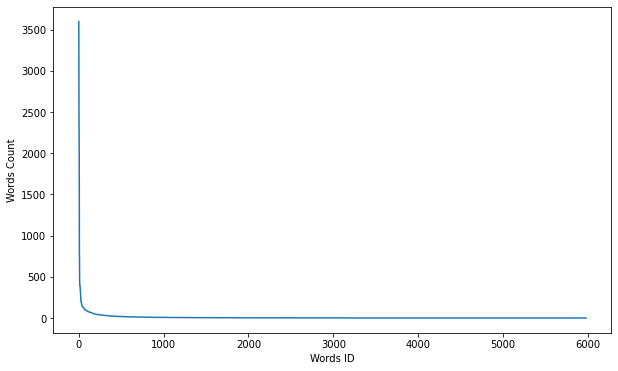

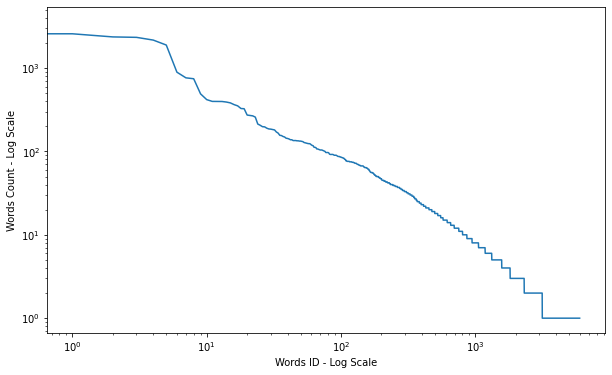

Different Words with (spacy) Stopwords: 5981
Top 10 Words with (spacy) Stopwords: ['the', 'of', 'and', 'be', 'in', 'to', 'have', 'pron', 'a', 'for']
Top 10 occurrences with (spacy) Stopwords: [3599, 2575, 2362, 2334, 2164, 1887, 892, 763, 744, 490]


In [78]:
# PLOT
#
# WordsCount vs Number of words
#
# and print the Top-5-stopwords and how often they occur

plt.figure(figsize=(10,6))
plt.plot(list(tokens_count.values()))
#plt.axhline(y = 1500, color = 'r', linestyle = '-')

plt.xlabel('Words ID')
plt.ylabel('Words Count')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(list(tokens_count.values()))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Words ID - Log Scale')
plt.ylabel('Words Count - Log Scale')
plt.show()

print("Different Words with (spacy) Stopwords:", len(tokens_count))
print("Top 10 Words with (spacy) Stopwords:", list(tokens_count.keys())[0:10])
print("Top 10 occurrences with (spacy) Stopwords:", list(tokens_count.values())[0:10])

**Create a dictionary of vocabulary:** Next, reduce the size of dictionary by considering a cut-off threshold on the tokens with low frequencies. When removing tokens from the dictionary, consider a strategy for handling Out-Of-Vocabulary (OOV) tokens, namely the ones in the train/validation/test datasets that that are not anymore in the dictionary. Some possible strategies could be to remove OOVs completely from the texts, or to replace them with a special token like <OOV\>. Explain your approaches and report the statistics of the dictionary before and after the reduction.

Exclude extremely frequent as well as extremely unfrequent *words* in the dictionary *italicized text*

In [87]:
dic = Dictionary(docs_train)
dic.filter_extremes(no_below=1, no_above=0.5, keep_n=20000)
dic.compactify()
print("Total %s unique tokens." % len(dic), '\n')

print('First 5 words: \n')
for _ in range(5):
  print(dic[_])

Total 5973 unique tokens. 

First 5 words: 

affect
alaotra
along
also
analamanga


In [95]:
docs_train[0][:10]

['the',
 'cyclone',
 'be',
 'be',
 'compare',
 'to',
 'the',
 'last',
 'hurricanestrength',
 'tropical']

In [96]:
dic.doc2bow(docs_train[0][:10])

[(14, 1), (16, 1), (31, 1), (34, 1), (67, 1)]

In [89]:
docs_train_bow = [dic.doc2bow(_doc) for _doc in docs_train] 
docs_val_bow = [dic.doc2bow(_doc) for _doc in docs_valid] 
docs_test_bow = [dic.doc2bow(_doc) for _doc in docs_test] 

## Creating sentence vectors

Using weight-model: tf-idf using ***gensim*** models

In [97]:
weight_model = TfidfModel(docs_train_bow)

docs_train_tfidf=[]
for _bow in docs_train_bow:
    docs_train_tfidf.append(weight_model[_bow])
    
docs_val_tfidf=[]
for _bow in docs_val_bow:
    docs_val_tfidf.append(weight_model[_bow])

docs_test_tfidf=[]
for _bow in docs_test_bow:
    docs_test_tfidf.append(weight_model[_bow])
    

In [98]:
docs_train_tfidf[42][:10]

[(15, 0.12713695105138673),
 (37, 0.10569290966728735),
 (61, 0.039870338370585644),
 (63, 0.059645726257885924),
 (74, 0.08745213718766404),
 (117, 0.06339175541512),
 (124, 0.031248800681375113),
 (216, 0.1207261782768153),
 (317, 0.07208975308532507),
 (336, 0.06585809755885022)]

In [101]:
docs_train_tfidf_sparse = np.zeros((len(docs_train_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_train_tfidf):
    for item in doc:
        docs_train_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_val_tfidf_sparse = np.zeros((len(docs_val_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_val_tfidf):
    for item in doc:
        docs_val_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_test_tfidf_sparse = np.zeros((len(docs_test_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_test_tfidf):
    for item in doc:
        docs_test_tfidf_sparse[doc_i][item[0]] = item[1]


In [102]:
docs_train_tfidf_sparse.shape

(840, 5973)

In [103]:
# Calculate and report the sparsity rate of the vectors of train, 
# validation, and test sets, namely what percentages of the vectors in each set are filled with zeros.

from numpy import count_nonzero

print("The sparsity rate of the tf-idf-variation is:\n")
sparsity = 1.0 - ( count_nonzero(docs_train_tfidf_sparse) / float(docs_train_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print("for the Training-Set:  ",percentage)
sparsity = 1.0 - ( count_nonzero(docs_val_tfidf_sparse) / float(docs_val_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print(f"for the Validation-Set:",percentage)
sparsity = 1.0 - ( count_nonzero(docs_test_tfidf_sparse) / float(docs_test_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print("for the Test-Set:      ",percentage)

The sparsity rate of the tf-idf-variation is:

for the Training-Set:   99.25602%
for the Validation-Set: 99.36780%
for the Test-Set:       99.31562%


#### Apply SVD for dimensionality reduction to 300 dimensions

In [105]:
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
svd.fit(docs_train_tfidf_sparse)

vecs_train = svd.transform(docs_train_tfidf_sparse)
vecs_val = svd.transform(docs_val_tfidf_sparse)
vecs_test = svd.transform(docs_test_tfidf_sparse)

print("These are the dimensions after the SVD of the tf-idf variant:")
print ("Training Set:   ", vecs_train.shape)
print ("Validation Set: ", vecs_val.shape)
print ("Test Set:       ", vecs_test.shape)

These are the dimensions after the SVD of the tf-idf variant:
Training Set:    (840, 300)
Validation Set:  (180, 300)
Test Set:        (180, 300)


#### Apply TSNE for further dimensionality reduction to 2 dimensions for plotting.

In [108]:
tsne = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random')
vecs_train_2dim = tsne.fit_transform(vecs_train)
print(f'After tsne the shape is: {vecs_train_2dim.shape}')

After tsne the shape is: (840, 2)


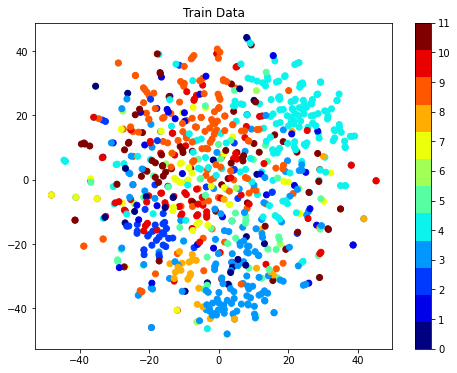

In [109]:
plt.figure(figsize=(8,6))
plt.scatter(vecs_train_2dim[:, 0], vecs_train_2dim[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", np.max(labels)+1))
plt.colorbar(ticks=range(14))
plt.title("Train Data")
# plt.clim(-0.5, 9.5)
plt.show()

# Training and Sentiment analysis

#### Dummy baseline

In [111]:
def dummy_classifier(train_set, labels, test_set):
    clf = DummyClassifier(strategy='stratified')
    clf.fit(train_set, labels)
    dummy_preds = clf.predict(test_set)
    return dummy_preds